In [1]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect
from time import sleep
sys.path.append('../util')
from meters import ThroughputMeter, clear_host_cache
from ncgen import make_nc
from grids import *
import netCDF4
import numpy as np

In [2]:
def write_netcdf_file(timescale, time_major=True, grid=canada_5k):
    print("Creating a time-{} NetCDF file with {}x{} grid and {} time steps".format('major' if time_major else 'minor', grid['lon']['count'], grid['lat']['count'],len(timescale)))
    with NamedTemporaryFile(suffix='.nc', delete=False, dir='/app/tmp') as f:
        nc = make_nc(f.name, grid=grid, timescale=timescale, timemajor=time_major)
        nc.close()
    print("File size: {:.2f}Mb".format(os.path.getsize(f.name)/1024/1024))
    return f

../tmp path in the Docker container points at rotating media storage.

In [3]:
def netcdf_read_test(f, time_major):
    # Open the file just created
    nc = netCDF4.Dataset(f.name, 'r')
    if time_major:
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][0,:,:]

    else:
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][:,:,0]
    res = (time_major, len(timescale), t.megabytes_per_second(a))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    del nc
    print("Removing {}".format(f.name))
    os.remove(f.name)
    f.close()
    collect()
    return res

### Test scenarios

In [4]:
time_major = [True, False]
grids = [world_250k, world_125k, canada_5k, bc_400m]
ts = [timescales['seasonal'], timescales['annual'], timescales['monthly']] # Daily takes hours and hours to run #, timescales['daily']]

In [5]:
results = []

for tm in time_major:
    for grid in grids:
        for timescale in ts:
            testfile = write_netcdf_file(timescale, time_major=tm, grid=grid)
            clear_host_cache()
            results.append(netcdf_read_test(testfile, tm))

Creating a time-major NetCDF file with 128x64 grid and 17 time steps
File size: 0.54Mb
host cache cleared
0.031 MB in 0.00142 seconds at 21.962 MB / sec
Removing /app/tmp/tmpn3eh5f0l.nc
Creating a time-major NetCDF file with 128x64 grid and 150 time steps
File size: 4.70Mb
host cache cleared
0.031 MB in 0.00109 seconds at 28.725 MB / sec
Removing /app/tmp/tmpy3a1l561.nc
Creating a time-major NetCDF file with 128x64 grid and 1800 time steps
File size: 56.26Mb
host cache cleared
0.031 MB in 0.00109 seconds at 28.662 MB / sec
Removing /app/tmp/tmpvff3ddgf.nc
Creating a time-major NetCDF file with 256x128 grid and 17 time steps
File size: 2.13Mb
host cache cleared
0.125 MB in 0.00163 seconds at 76.628 MB / sec
Removing /app/tmp/tmpgjvvswo7.nc
Creating a time-major NetCDF file with 256x128 grid and 150 time steps
File size: 18.76Mb
host cache cleared
0.125 MB in 0.0398 seconds at 3.140 MB / sec
Removing /app/tmp/tmpy7a24zc5.nc
Creating a time-major NetCDF file with 256x128 grid and 1800 tim

## Summarize Results

In [6]:
results

[(True, 17, 21.962466487935657),
 (True, 150, 28.724961648038573),
 (True, 1800, 28.662147386835777),
 (True, 17, 76.627886582870502),
 (True, 150, 3.1396559054788038),
 (True, 1800, 78.181926632866094),
 (True, 17, 37.210001366306869),
 (True, 150, 36.85499695513905),
 (True, 1800, 217.57826933639586),
 (True, 17, 32.346174067242316),
 (True, 150, 144.48089715459895),
 (True, 1800, 170.4861467168169),
 (False, 17, 10.258433122016124),
 (False, 150, 1.2334214760932369),
 (False, 1800, 0.10164023921189111),
 (False, 17, 1.2962377833653507),
 (False, 150, 1.1051718504621677),
 (False, 1800, 0.56720683995919219),
 (False, 17, 10.3329962070327),
 (False, 150, 3.4528857845726186),
 (False, 1800, 0.10451378026871384),
 (False, 17, 15.184090236477548),
 (False, 150, 1.2433207499992507),
 (False, 1800, 0.10429545285052902)]

Reshape to dimensions timescale, grid, time_major

In [7]:
a = np.array([r[2] for r in results]).reshape(len(time_major),len(grids),len(ts))
a

array([[[  2.19624665e+01,   2.87249616e+01,   2.86621474e+01],
        [  7.66278866e+01,   3.13965591e+00,   7.81819266e+01],
        [  3.72100014e+01,   3.68549970e+01,   2.17578269e+02],
        [  3.23461741e+01,   1.44480897e+02,   1.70486147e+02]],

       [[  1.02584331e+01,   1.23342148e+00,   1.01640239e-01],
        [  1.29623778e+00,   1.10517185e+00,   5.67206840e-01],
        [  1.03329962e+01,   3.45288578e+00,   1.04513780e-01],
        [  1.51840902e+01,   1.24332075e+00,   1.04295453e-01]]])

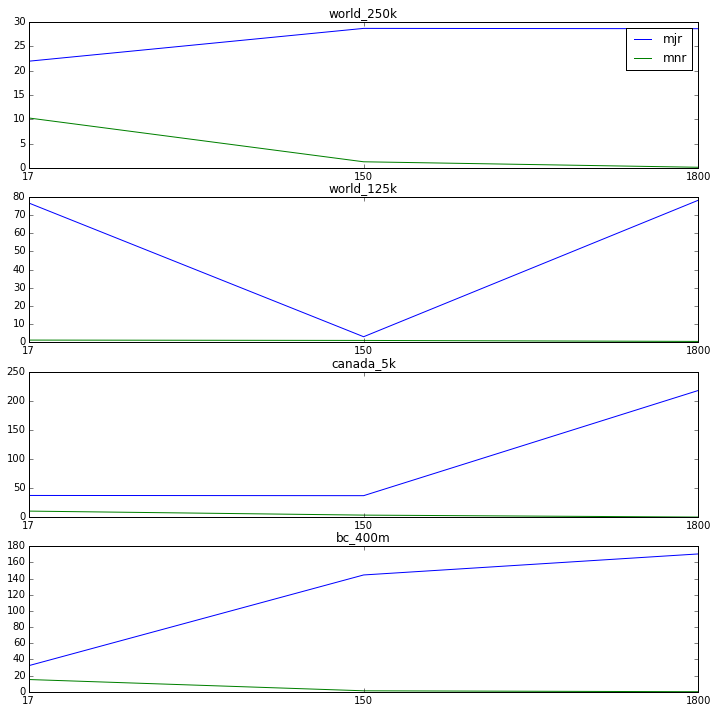

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
f.set_size_inches(12, 12)

ax1.plot(a[0,0,:], label="mjr")
ax1.plot(a[1,0,:], label="mnr")
ax1.legend()
ax1.set_title("world_250k")
ax1.set_xticks(range(len(ts)))
ax1.set_xticklabels([len(x) for x in ts])

ax2.plot(a[0,1,:], label="mjr")
ax2.plot(a[1,1,:], label="mnr")
ax2.set_title("world_125k")
ax2.set_xticks(range(len(ts)))
ax2.set_xticklabels([len(x) for x in ts])

ax3.plot(a[0,2,:], label="mjr")
ax3.plot(a[1,2,:], label="mnr")
ax3.set_title("canada_5k")
ax3.set_xticks(range(len(ts)))
ax3.set_xticklabels([len(x) for x in ts])

ax4.plot(a[0,3,:], label="mjr")
ax4.plot(a[1,3,:], label="mnr")
ax4.set_title("bc_400m")
ax4.set_xticks(range(len(ts)))
ax4.set_xticklabels([len(x) for x in ts])

### Time-major readout of NetCDF files is consistently better, and gets somewhat faster as the spatial grid gets more dense.  Time-minor readout gets consistently worse with increasing number of time steps.